In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import json
import glob
from PIL import Image
import re
import random

# # Download Wordnet through NLTK in python console:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models, similarities, matutils

from sklearn.preprocessing import normalize;
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# this is where my copy of the data is, you should change this for your needs
df = pd.read_csv('/content/drive/My Drive/FourthBrain/individual_project/train.csv')

In [ ]:
print(df.dtypes)
print(df.shape)
df.head()

id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object
(159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
df.columns.tolist()

['id',
 'comment_text',
 'toxic',
 'severe_toxic',
 'obscene',
 'threat',
 'insult',
 'identity_hate']

In [ ]:
df['comment_text']

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159566    ":::::And for the second time of asking, when ...
159567    You should be ashamed of yourself \n\nThat is ...
159568    Spitzer \n\nUmm, theres no actual article for ...
159569    And it looks like it was actually you who put ...
159570    "\nAnd ... I really don't think you understand...
Name: comment_text, Length: 159571, dtype: object

In [ ]:
def lemmatize_stemming(token):
    #return SnowballStemmer("english").stem(WordNetLemmatizer().lemmatize(doc, pos='v'))
    return WordNetLemmatizer().lemmatize(token, pos='v')

def preprocess(doc):
    result = []
    
    add_stop_words = ["wa","ha","one","two","id","re","http", "https", "com","mr","image","photo","caption",
                      "don","sen","pic","co", "source","watch","play","duration","video","momentjs",
                      "getty","images","newsletter", "story", "go", "like", "say", "will", "just", 
                      "today", "can", "year", "make", "view", "read", 'aposs', 'apost', 'aposre','click', 
                      'copyright', 'comment']

    # Add new stop words
    stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)
    
    for token in gensim.utils.simple_preprocess(doc):
        #if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
        if token not in stop_words and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return ' '.join(result)


df['refined_article'] = df['comment_text'].map(preprocess)

In [ ]:
df['refined_article'][22][:1000]

'snowflakes symmetrical geometry state snowflake symmetric arm assertion simply true accord kenneth libbrecht unattractive irregular crystals common variety caltech atomic snowcrystals myths myths perfection really need look site facts decent number falsities page forgive dont want edit'

In [ ]:
df['refined_article'][123200]

'anbody rely wikipedia information fool york daily news rush molloy homeautosreal ticketscontests loginregister molloycelebrity section brokaw rogue wacky pedia sunday march jacobs debate moderator brokaw talk prior town hall presidential debate belmont university curb event center relate news article celebrity dish john malkovich brush bernie madoff shoulder hanks film help buck tough time journalism beloved respect appear brokaw look news anchor wikipedia review emmy win report best sell book honorary degrees recently sentence marry meredith lynn auld miss south dakota author allege affair brokaw diane sawyer end marriage brokaws marriage intact google search show events likewise news sawyer remain happily marry director mike nichols brokaw say burst laugh hear suppose affair contact arctic reach finland sawyer send word cute laugh hard nearly fell icebreaker travel purport affair anonymously add brokaw delete days wikipedia foundation spokesman walsh tell post constitute vandal edit

In [ ]:
count_vectorizer = CountVectorizer(ngram_range=(1, 1),  
                                   stop_words='english',
                                   #stop_words=stop_words,
                                   token_pattern="\\b[a-z][a-z]+\\b", 
                                   lowercase = True, 
                                   max_df=1.0, 
                                   min_df=1,)

In [ ]:
doc_word = count_vectorizer.fit_transform(df['refined_article']) 

In [ ]:
doc_word.shape

(159571, 145112)

In [ ]:
# Initialise the TfidfCountVectorizer with the English stop words
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),  
                                        binary=True,
                                        stop_words='english', 
                                        token_pattern="\\b[a-z][a-z]+\\b")


# Fit and transform the processed titles
doc_word_tfidf = tfidf_vectorizer.fit_transform(df['refined_article'])#.transpose()


doc_word_tfidf_norm = normalize(doc_word_tfidf, norm='l1', axis=1)
doc_word_tfidf.shape

(159571, 2180697)

In [ ]:
# Acronynms: Latent Semantic Analysis (LSA) is just another name for 
#  Signular Value Decomposition (SVD) applied to Natural Language Processing (NLP)
n_components = 20
lsa = TruncatedSVD(n_components)
doc_topic = lsa.fit_transform(doc_word)
lsa.explained_variance_ratio_

array([0.05981774, 0.0336947 , 0.03275908, 0.03196683, 0.03066217,
       0.02866589, 0.02864754, 0.02353599, 0.02111703, 0.01816914,
       0.019866  , 0.01632939, 0.01614553, 0.01613742, 0.01613396,
       0.01476979, 0.01233303, 0.01064779, 0.01116305, 0.011119  ])

In [ ]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ['component_' + str(i) for i in range(n_components)],
             columns = count_vectorizer.get_feature_names())
topic_word

,aaaa,aaaaa,aaaaaaaa,aaaaaaaaaah,aaaaaaaaadm,aaaaaaaaaq,aaaaaaaacfo,aaaaaaaaczy,aaaaaaaari,aaaaaaaayui,aaaaaaw,aaaaah,aaaah,aaaawwww,aaaboyz,aaages,aaaghh,aaah,aaahhh,aaahs,aaai,aaajade,aaand,aaarrrgggh,aaaww,aaba,aaberg,aabove,aacargo,aacd,aachen,aachi,aacs,aadd,aademia,aadil,aadmi,aadministrators,aadu,aaets,...,zwginolqtk,zwicky,zwie,zwktaotgeu,zwoiw,zwol,zwolle,zworykin,zwyke,zxcvbnm,zxpdlmodo,zxyejaeo,zyan,zyar,zybez,zydeco,zydyaon,zyeno,zygarchy,zygon,zygote,zygotes,zyklon,zynga,zythe,zyuranger,zyxoas,zyxw,zyzzyxrd,zyzzzzy,zyzzzzzy,zzaroc,zzem,zzet,zzteu,zzuuzz,zzyzwicz,zzzz,zzzzz,zzzzzzz
component_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
component_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
component_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
component_3,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
component_4,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0
component_5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
component_6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
component_7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
component_8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
component_9,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.

In [ ]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        


def get_top_word_of_topics(model, vectorizer, num_topics, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-n_top_words - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict)

In [ ]:
display_topics(lsa, count_vectorizer.get_feature_names(), 15)


Topic  0
fuck, bitch, yourselfgo, niggas, wikipedia, shut, shit, useless, cunt, suck, atheist, faggot, nigger, cocksucking, pussy

Topic  1
nigger, faggot, shit, cunt, stupid, tommy, huge, delanoy, licker, suck, damn, piece, cocksucking, jforget, chink

Topic  2
faggot, shit, huge, suck, piece, edit, user, dick, edgar, cocksucking, remove, work, cock, nice, mexicans

Topic  3
shit, suck, cock, dick, user, mexicans, edgar, anthony, bradbury, cocksucking, admins, cunts, bitch, nigga, shoot

Topic  4
suck, dick, cock, mexicans, bush, veggietales, robert, ullmann, lick, faggot, pussy, anthony, bradbury, want, mother

Topic  5
fish, bark, wikipedia, article, block, page, hate, edit, talk, time, know, people, use, write, delete

Topic  6
bark, wikipedia, block, article, page, best, edit, hate, talk, know, people, think, use, time, work

Topic  7
hate, wikipedia, block, article, page, edit, talk, delete, thank, deletion, think, use, question, know, people

Topic  8
block, wikipedia, article,

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS 
from PIL import Image
import requests
from io import BytesIO




def display_topic_wordcloud(model, feature_names, no_top_words, masked=False):
    
    response = requests.get("https://cdn2.iconfinder.com/data/icons/once-more-into-the-breach/60/explosion-512.png")
    background_mask = np.array(Image.open(BytesIO(response.content)))


    topic_dic = {}
    for ix, topic in enumerate(model.components_):
        text = ", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        topic_dic['Topic' + str(ix)] = text
        
    
        #Create and generate a word cloud image:
        if masked:
            wordcloud = WordCloud(mask=background_mask).generate(text)
        
        else:
            wordcloud = WordCloud().generate(text)
        
        
        # lower max_font_size, change the maximum number of word and lighten the background:
        #wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

        # Display the generated image:
        #plt.figure(figsize=(16, 12))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
    
        # Save the image in the img folder:
        #wordcloud.to_file("img.png")
    
    #return topic_dic

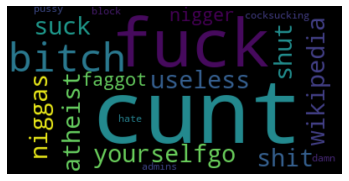

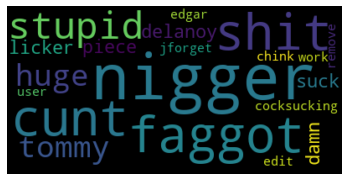

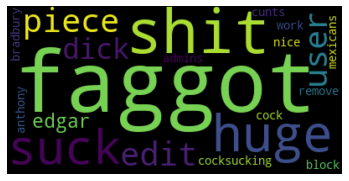

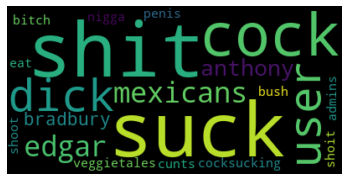

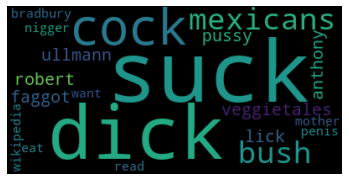

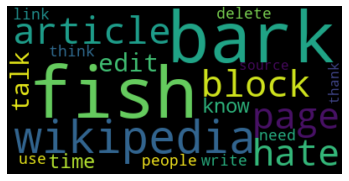

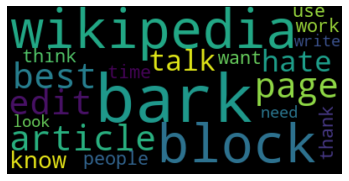

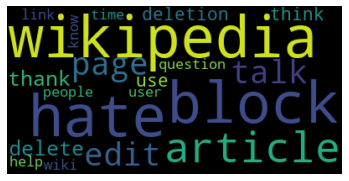

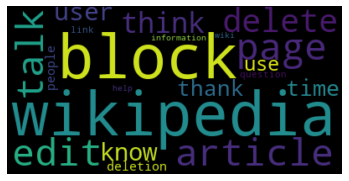

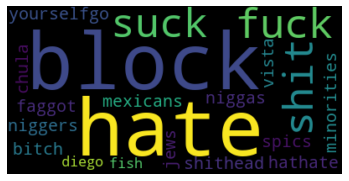

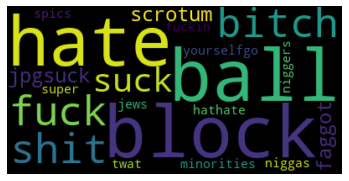

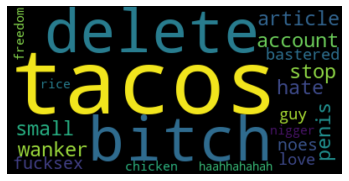

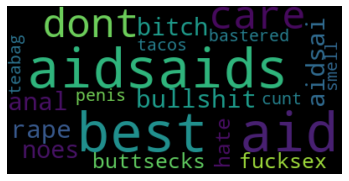

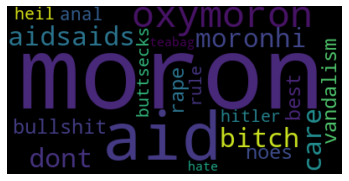

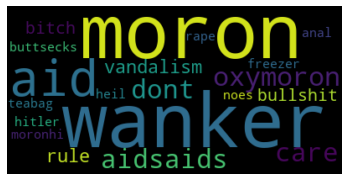

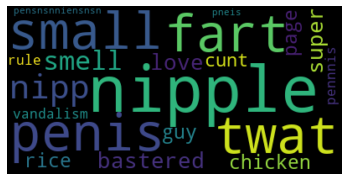

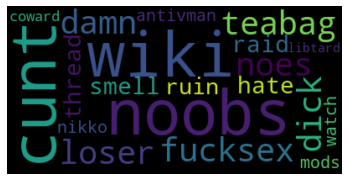

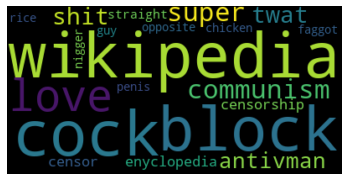

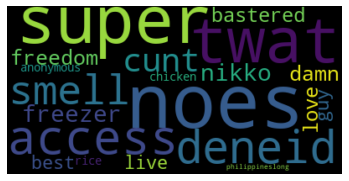

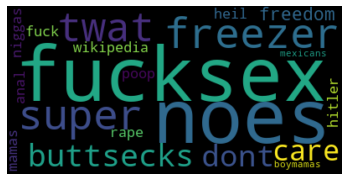

In [ ]:
display_topic_wordcloud(lsa, count_vectorizer.get_feature_names(), 20)

In [ ]:
get_top_word_of_topics(lsa, count_vectorizer, n_components, 20)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12,Topic # 13,Topic # 14,Topic # 15,Topic # 16,Topic # 17,Topic # 18,Topic # 19,Topic # 20
0,fuck,nigger,faggot,shit,suck,fish,bark,hate,block,block,ball,tacos,aid,moron,wanker,nipple,wiki,wikipedia,noes,fucksex
1,bitch,faggot,shit,suck,dick,bark,wikipedia,wikipedia,wikipedia,hate,block,bitch,aidsaids,aid,moron,penis,noobs,cock,super,noes
2,yourselfgo,shit,huge,cock,cock,wikipedia,block,block,article,fuck,hate,delete,best,oxymoron,aid,fart,cunt,block,twat,freezer
3,niggas,cunt,suck,dick,mexicans,article,article,article,page,shit,fuck,account,care,aidsaids,oxymoron,small,teabag,love,access,super
4,wikipedia,stupid,piece,user,bush,block,page,page,edit,suck,shit,stop,dont,dont,aidsaids,twat,fucksex,communism,deneid,twat
5,shut,tommy,edit,mexicans,veggietales,page,best,edit,talk,yourselfgo,bitch,penis,bullshit,care,dont,nipp,noes,super,smell,buttsecks
6,shit,huge,user,edgar,robert,hate,edit,talk,delete,bitch,suck,wanker,rape,bitch,care,smell,damn,shit,cunt,dont
7,useless,delanoy,dick,anthony,ullmann,edit,hate,delete,think,faggot,jpgsuck,small,aidsai,moronhi,vandalism,bastered,loser,twat,freezer,care
8,cunt,licker,edgar,bradbury,lick,talk,talk,thank,user,spics,scrotum,article,anal,bullshit,rule,love,dick,antivman,nikko,freedom
9,suck,suck,cocksucking,cocksucking,faggot,time,know,deletion,know,niggers,faggot,hate,bitch,noes,bullshit,super,smell,enyclopedia,freedom,wikipedia


In [ ]:
# Acronynms: Latent Semantic Analysis (LSA) is just another name for 
#  Signular Value Decomposition (SVD) applied to Natural Language Processing (NLP)
n_components = 20
lsa = TruncatedSVD(n_components)
doc_topic_tfidf  = lsa.fit_transform(doc_word_tfidf) #doc_word_tfidf_norm
lsa.explained_variance_ratio_

array([0.00210569, 0.00239205, 0.00230516, 0.00185329, 0.0015474 ,
       0.00135078, 0.00123184, 0.00115022, 0.00106529, 0.00102834,
       0.00090642, 0.00082509, 0.00079429, 0.00077518, 0.00074857,
       0.00070293, 0.00064099, 0.00062593, 0.00061402, 0.00060747])

In [ ]:
topic_word_tfidf = pd.DataFrame(lsa.components_.round(3),
             index = ['component_' + str(i) for i in range(n_components)],
             columns = tfidf_vectorizer.get_feature_names())
topic_word_tfidf

,aaaa,aaaa dream,aaaa rubaiyat,aaaaa,aaaaa forget,aaaaa ukraine,aaaaa upload,aaaaa write,aaaaaaaa,aaaaaaaa group,aaaaaaaaaah,aaaaaaaaaah change,aaaaaaaaadm,aaaaaaaaadm edau,aaaaaaaaaq,aaaaaaaaaq kpiivnfneei,aaaaaaaacfo,aaaaaaaacfo expz,aaaaaaaaczy,aaaaaaaaczy mermaid,aaaaaaaari,aaaaaaaari bchicago,aaaaaaaayui,aaaaaaaayui unemgrj,aaaaaaw,aaaaaaw dengan,aaaaah,aaaaah think,aaaah,aaaah good,aaaawwww,aaaawwww widdle,aaaboyz,aaaboyz hotmail,aaages,aaages time,aaaghh,aaaghh time,aaah,aaah gladstone,...,zythe,zythe know,zythe talk,zyuranger,zyuranger dairanger,zyxoas,zyxoas prize,zyxoas talk,zyxw,zyxw nice,zyzzyxrd,zyzzyxrd cite,zyzzzzy,zyzzzzy change,zyzzzzzy,zyzzzzzy reply,zzaroc,zzaroc black,zzaroc sorry,zzem,zzem edit,zzet,zzteu,zzteu people,zzuuzz,zzuuzz nazi,zzuuzz rap,zzuuzz talk,zzyzwicz,zzyzwicz talk,zzzz,zzzz aftah,zzzz oregon,zzzz people,zzzz template,zzzzz,zzzzz remove,zzzzz tssr,zzzzzzz,zzzzzzz youre
component_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
component_1,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000,-0.0,-0.0,-0.000,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
component_2,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.001,0.0,0.0,0.001,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
component_3,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.000,-0.0,-0.0,0.000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
component_4,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.000,-0.0,-0.0,0.000,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
component_5,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.000,-0.0,0.0,0.000,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
component_6,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,...,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.000,-0.0,-0.0,0.000,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
component_7,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,...,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0

In [ ]:
display_topics(lsa, tfidf_vectorizer.get_feature_names(), 15)


Topic  0
talk, page, thank, wikipedia, edit, article, talk page, block, welcome, remove, block edit, continue, want, look, revert

Topic  1
learn contribute, welcome page, sandbox, sandbox test, test want, page learn, contribute encyclopedia, look welcome, experiment, thank experiment, test work, wikipedia test, want look, remove sandbox, revert remove

Topic  2
block, block edit, vandalize, continue, vandalize page, edit, stop, continue vandalize, stop continue, continue block, page edit, vandalize wikipedia, edit wikipedia, wikipedia block, wikipedia

Topic  3
block edit, welcome, vandalize, block, continue, edit, welcome wikipedia, tildes, use tildes, pillars wikipedia, pillars, tildes automatically, enjoy edit, hope enjoy, manual style

Topic  4
speedy deletion, speedy, speedily delete, speedily, delete wikipedia, remove speedy, criteria speedy, deletion article, explain position, block edit, request speedily, page explain, criteria, contest, hesitate information

Topic  5
talk, t

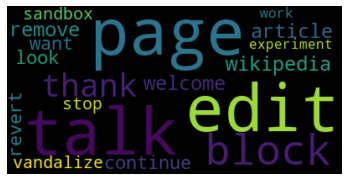

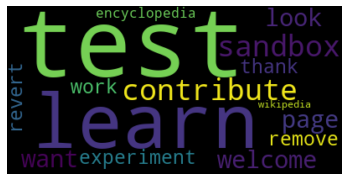

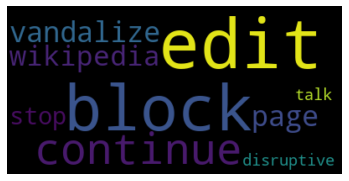

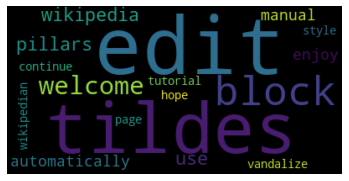

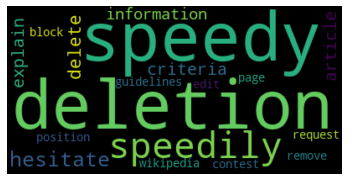

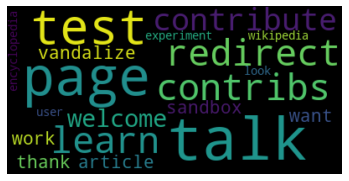

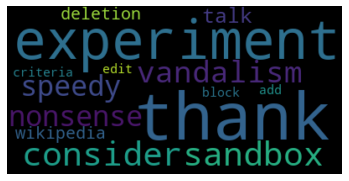

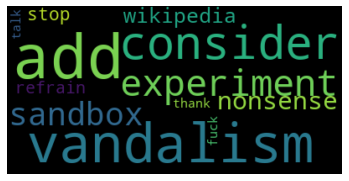

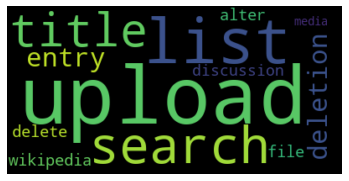

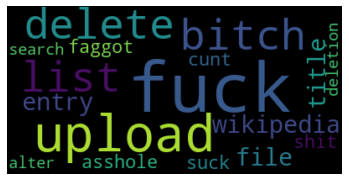

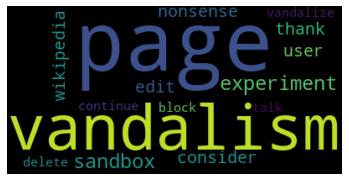

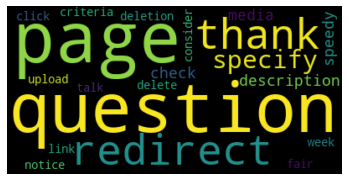

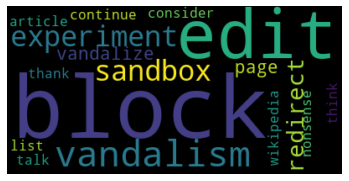

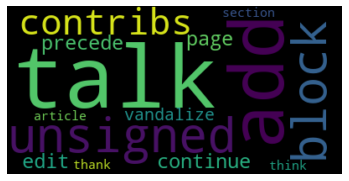

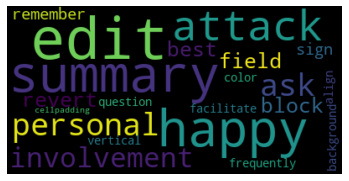

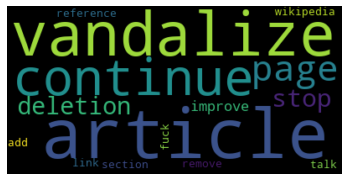

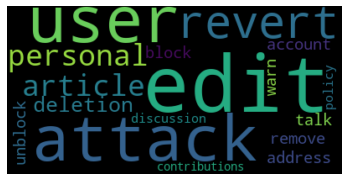

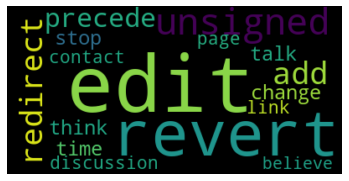

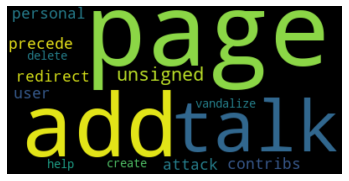

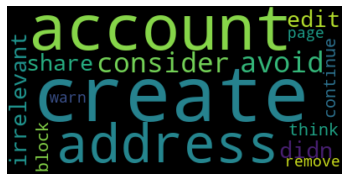

In [ ]:
display_topic_wordcloud(lsa, tfidf_vectorizer.get_feature_names(), 20)

In [ ]:
get_top_word_of_topics(lsa, tfidf_vectorizer, n_components, 20)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12,Topic # 13,Topic # 14,Topic # 15,Topic # 16,Topic # 17,Topic # 18,Topic # 19,Topic # 20
0,talk,learn contribute,block,block edit,speedy deletion,talk,thank,vandalism,upload,fuck,page,redirect,redirect,contribs,edit,article,block,edit,page,think
1,page,welcome page,block edit,welcome,speedy,talk page,experiment sandbox,consider vandalism,list wikipedia,fuck fuck,talk page,redirect talk,redirect talk,talk contribs,attack,vandalize,edit,revert,add,didn
2,thank,sandbox,vandalize,vandalize,speedily delete,redirect talk,consider vandalism,experiment sandbox,delete,bitch,page edit,thank upload,continue block,add,revert,link,user,revert edit,redirect,continue block
3,wikipedia,sandbox test,continue,block,speedily,redirect,vandalism experiment,vandalism experiment,file upload,shit,vandalize page,fair,vandalize page,unsigned,personal attack,fuck,attack,stop,redirect talk,create account
4,edit,test want,vandalize page,continue,delete wikipedia,page,sandbox thank,nonsense wikipedia,search title,asshole,continue block,link,page edit,unsigned add,edit summary,remove,remove,add,unsigned,address
5,article,page learn,edit,edit,remove speedy,talk contribs,thank talk,consider,title entry,delete,vandalism,specify,block,precede unsigned,personal,vandalize page,revert,change,unsigned add,avoid irrelevant
6,talk page,contribute encyclopedia,stop,welcome wikipedia,criteria speedy,contribs,nonsense wikipedia,nonsense,list deletion,cunt,edit,description page,article,precede,happy edit,wikipedia,personal,redirect,precede unsigned,remove
7,block,look welcome,continue vandalize,tildes,deletion article,vandalize page,wikipedia consider,sandbox,upload alter,fuck bitch,consider vandalism,media question,vandalize,add talk,summary,article talk,personal attack,redirect talk,precede,account
8,welcome,experiment,stop continue,use tildes,explain position,article talk,vandalism,wikipedia consider,list,suck,experiment sandbox,check specify,block edit,continue block,block,stop continue,article,time,delete,account avoid
9,remove,thank experiment,continue block,pillars wikipedia,block edit,learn contribute,talk,experiment,entry delete,faggot,vandalism experiment,description,edit,page edit,happy,continue vandalize,warn,edit revert,user,consider create


In [ ]:
n_components = 20
nmf_model = NMF(n_components)
doc_topic = nmf_model.fit_transform(doc_word)

In [ ]:
display_topics(nmf_model, count_vectorizer.get_feature_names(), 10)


Topic  0
fuck, bitch, yourselfgo, niggas, shut, useless, cunt, atheist, cocksucking, pussy

Topic  1
nigger, cunt, stupid, tommy, delanoy, licker, damn, piece, jforget, chink

Topic  2
faggot, huge, piece, nice, work, remove, edit, jforget, chink, raid

Topic  3
shit, user, edgar, cocksucking, piece, anthony, bradbury, admins, cunts, nigga

Topic  4
suck, dick, cock, mexicans, bush, veggietales, robert, ullmann, lick, pussy

Topic  5
fish, life, time, write, soup, people, plant, know, conflict, pond

Topic  6
bark, know, people, think, london, little, work, tree, refer, cowan

Topic  7
hate, jews, minorities, niggers, spics, hathate, people, ersi, thank, wikipedia

Topic  8
block, edit, talk, user, continue, post, kill, say, blank, right

Topic  9
article, page, edit, talk, delete, think, deletion, know, thank, time

Topic  10
ball, scrotum, jpgsuck, right, fuckin, allemande, come, know, damn, rodeo

Topic  11
tacos, delete, stop, account, taco, shall, shell, henry, puffy, brother

To

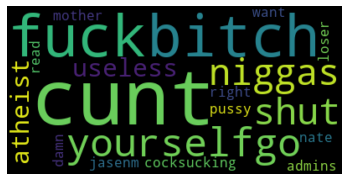

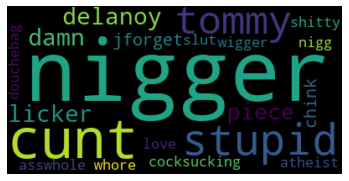

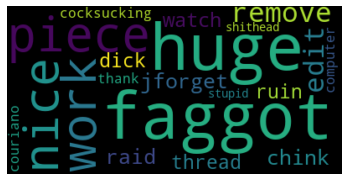

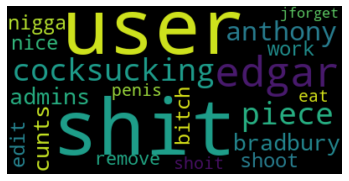

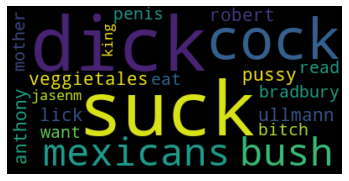

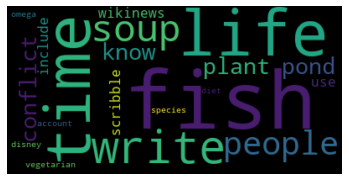

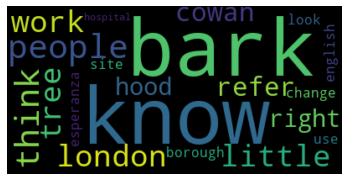

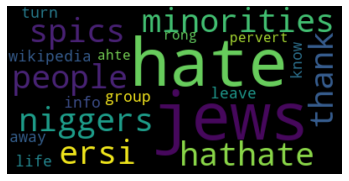

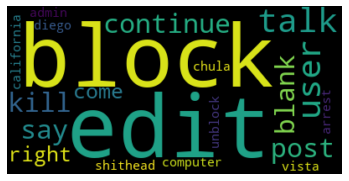

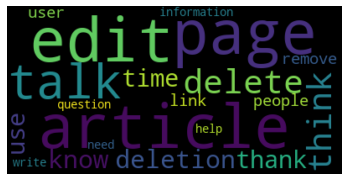

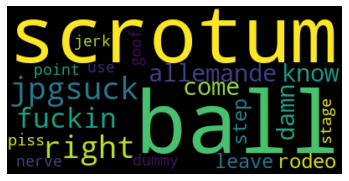

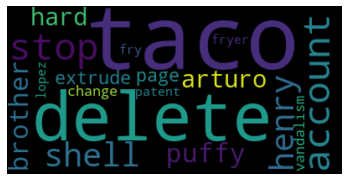

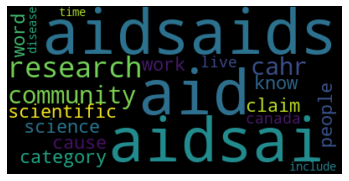

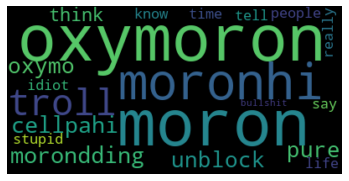

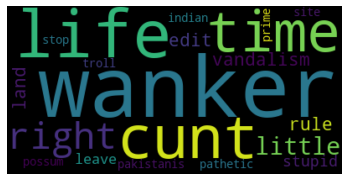

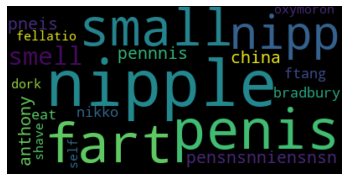

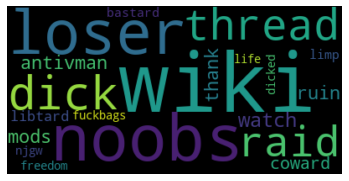

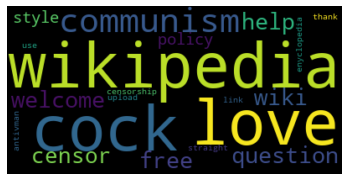

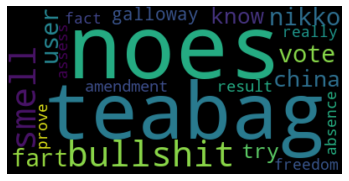

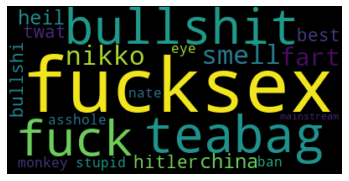

In [ ]:

#display_topic_wordcloud(nmf_model, count_vectorizer.get_feature_names(), 20)
display_topic_wordcloud(nmf_model, count_vectorizer.get_feature_names(), 20)

In [ ]:
get_top_word_of_topics(nmf_model, count_vectorizer, n_components, 20)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12,Topic # 13,Topic # 14,Topic # 15,Topic # 16,Topic # 17,Topic # 18,Topic # 19,Topic # 20
0,fuck,nigger,faggot,shit,suck,fish,bark,hate,block,article,ball,tacos,aid,moron,wanker,nipple,wiki,wikipedia,noes,fucksex
1,bitch,cunt,huge,user,dick,life,know,jews,edit,page,scrotum,delete,aidsaids,oxymoron,life,penis,noobs,love,teabag,teabag
2,yourselfgo,stupid,piece,edgar,cock,time,people,minorities,talk,edit,jpgsuck,stop,aidsai,moronhi,cunt,fart,loser,cock,bullshit,bullshit
3,niggas,tommy,nice,cocksucking,mexicans,write,think,niggers,user,talk,right,account,research,troll,time,small,dick,communism,smell,fuck
4,shut,delanoy,work,piece,bush,soup,london,spics,continue,delete,fuckin,taco,community,morondding,right,nipp,thread,question,nikko,smell
5,useless,licker,remove,anthony,veggietales,people,little,hathate,post,think,allemande,shall,cahr,cellpahi,little,smell,raid,welcome,vote,nikko
6,cunt,damn,edit,bradbury,robert,plant,work,people,kill,deletion,come,shell,scientific,unblock,vandalism,pensnsnniensnsn,watch,help,user,fart
7,atheist,piece,jforget,admins,ullmann,know,tree,ersi,say,know,know,henry,people,pure,land,pennnis,antivman,free,fart,china
8,cocksucking,jforget,chink,cunts,lick,conflict,refer,thank,blank,thank,damn,puffy,cause,oxymo,rule,pneis,ruin,wiki,china,heil
9,pussy,chink,raid,nigga,pussy,pond,cowan,wikipedia,right,time,rodeo,brother,category,think,edit,china,thank,censor,know,hitler


https://github.com/dvu4/metis_datascience/blob/master/projects/project4/p4_3_topic_modeling.ipynb